# Delay Scan -  DESC fringes on ExitScreen

In [1]:
import h5py;
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from IPython.display import Image

from scipy.optimize import curve_fit
from scipy.stats import kde

### Plot settings 

In [2]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize' : (10,10)})

### Utility functions

In [3]:
def count_nans(array):
    return np.count_nonzero(np.isnan(array))  

def count_non_nans(array):
    return len(array)-count_nans(array)

## DAQ run with delay scan

In [4]:
run_number = 28496

data_dir = '/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/'
hdf_filename = 'FLASH1_USER1-run'+str(run_number)+'.h5'
image_path = '/home/cpassow/DESC-commissioning/processed/fringes/fig/'

print(data_dir+hdf_filename)

/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/FLASH1_USER1-run28496.h5


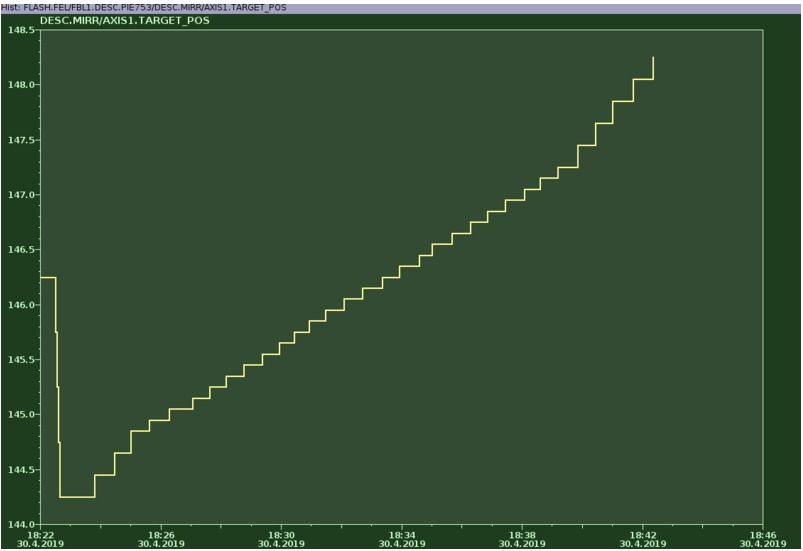

In [5]:
Image("delaymotor_history.jpeg")

### Read and Plot Delay Stage Positions

In [6]:
hdf_file = h5py.File(data_dir+hdf_filename,'r')
motor_pos_fine = hdf_file['/FL1/Experiment/BL1/CAMP/DESC/Fine delay stage/position'][()]
motor_pos_coarse = hdf_file['/FL1/Experiment/BL1/CAMP/DESC/Coarse delay stage/position'][()]

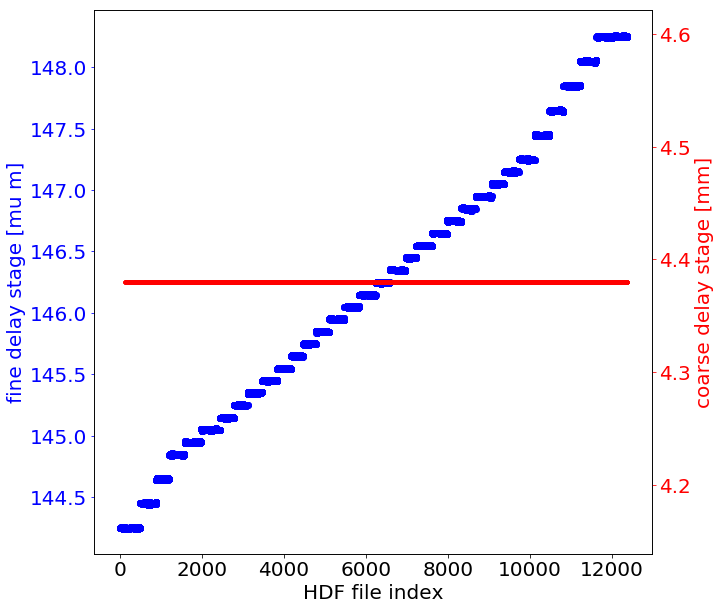

In [7]:
fig, ax1 = plt.subplots()
ax1.plot(motor_pos_fine,'bo')
ax1.set_xlabel('HDF file index')
ax1.set_ylabel('fine delay stage [mu m]', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(motor_pos_coarse,'r.')
ax2.set_ylabel('coarse delay stage [mm]', color='r')
ax2.tick_params('y', colors='r')

plt.show()

### Check Motor Positions for NaNs

In [8]:
print('Number of NaNs inf Fine Delay Stage:', count_nans(motor_pos_fine))
print('Number of NaNs inf Coarse Delay Stage:', count_nans(motor_pos_coarse))

Number of NaNs inf Fine Delay Stage: 831
Number of NaNs inf Coarse Delay Stage: 963


### Calculate Time Delay between Pump and Probe Beam

$$  \Delta t = \Delta z (1 + \cos(\alpha)) / c     $$ 

with

$$ \Delta z = z_{\text{long}} - 4.38 \text{mm} + z_{\text{short}} - 125.65 \mu \text{m}  $$
$$ \alpha = 0.7 ^\circ $$

Ref.: https://doi.org/10.1107/S1600577518006094

transpose timeDelay in femto seconds 

963 NaNs out of 13200 data points


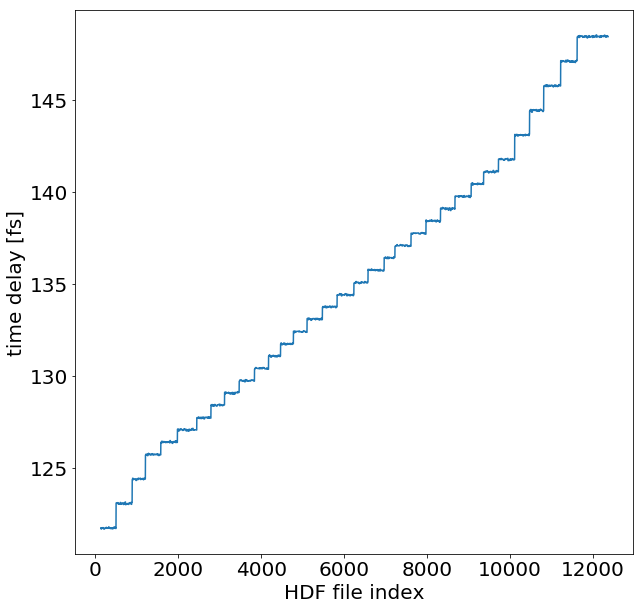

In [9]:
time_delay = (motor_pos_fine/1000000+motor_pos_coarse/1000-0.00438-0.000126)*(1+np.cos(0.7*np.pi/180))/299792458
print('{} NaNs out of {} data points'.format(count_nans(time_delay),time_delay.shape[0]))

time_delay = time_delay*1E15

plt.plot( time_delay)
plt.xlabel('HDF file index')
plt.ylabel('time delay [fs]')
plt.show()

### Find Delay Steps

/software/anaconda3/5.2/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


Number of Delay Steps:  33
[498, 887, 1206, 1577, 1978, 2445, 2787, 3115, 3468, 3837, 4176, 4466, 4776, 5105, 5475, 5830, 6235, 6576, 6965, 7225, 7613, 7974, 8324, 8673, 9064, 9364, 9722, 10113, 10472, 10813, 11222, 11620]


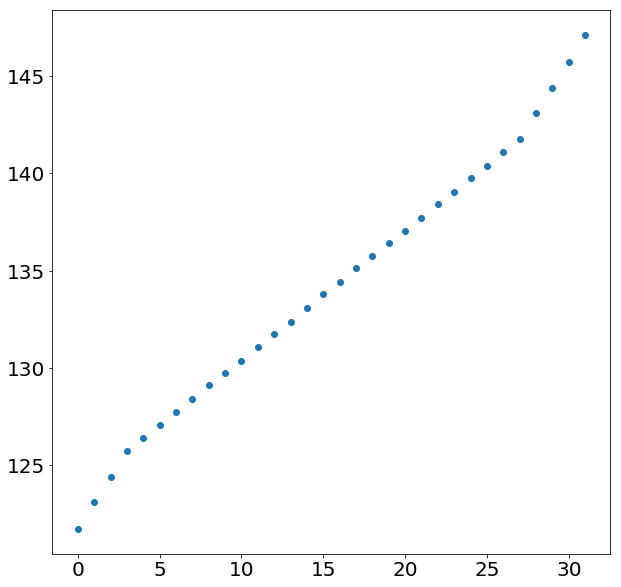

In [10]:
time_delay_treshold = 0.5 # in fs

res_delay = np.asarray([x -y for x,y in zip(time_delay, time_delay[1:])])
res_delay = np.append(res_delay,0)
change_delay = (np.abs(res_delay) > time_delay_treshold)
print('Number of Delay Steps: ',np.count_nonzero(change_delay) +1 )

index_delay_change = [i for i, val in enumerate(change_delay) if val] 
print(index_delay_change)

plt.plot(time_delay[index_delay_change],'o')
plt.show()

## Read Images from h5 file 

In [11]:
img = hdf_file['/uncategorised/FLASH1_USER1/FLASH.FEL/FBL1.CAM/EXIT_SCREEN/dset'][()]
print(type(img),'|',img.shape)

<class 'numpy.ndarray'> | (13200, 1280, 960)


### Define ROI and Calculate Integral of ROI for all Images

In [12]:
roi_x1, roi_y1 = 200, 100
roi_x2, roi_y2 = 700, 700

integral = np.asarray([np.sum(img[index][roi_x1:roi_x2,roi_y1:roi_y2]) for index in range(0,img.shape[0])])

### Plot Degree of Exposure & Delay Steps

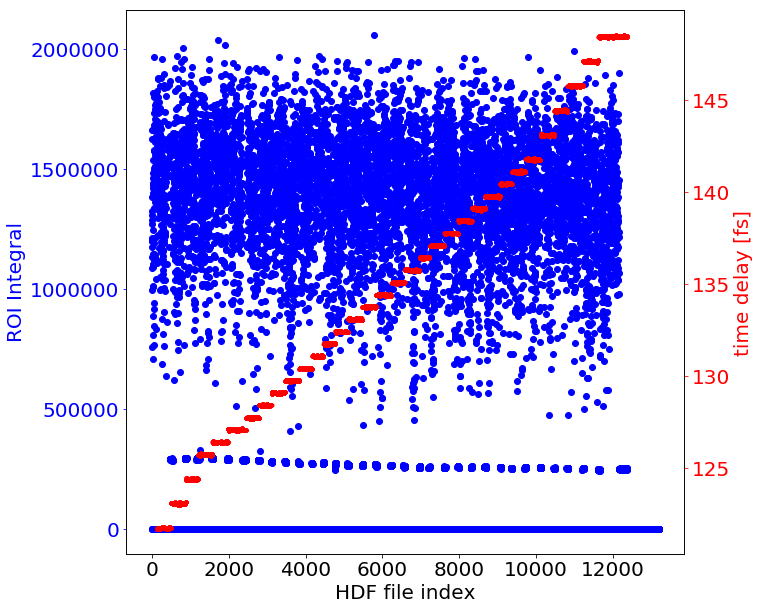

In [13]:
fig, ax1 = plt.subplots()
ax1.plot(integral,'bo')
ax1.set_xlabel('HDF file index')
ax1.set_ylabel('ROI Integral', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(time_delay,'r.')
ax2.set_ylabel('time delay [fs]', color='r')
ax2.tick_params('y', colors='r')

plt.show()

* We see that we have 3 types of images: real images (fringes), dark images (blocked shutter) & zeros (DAQ drops)
* 33 delay steps 
* drift in darks? 

### Zooming In

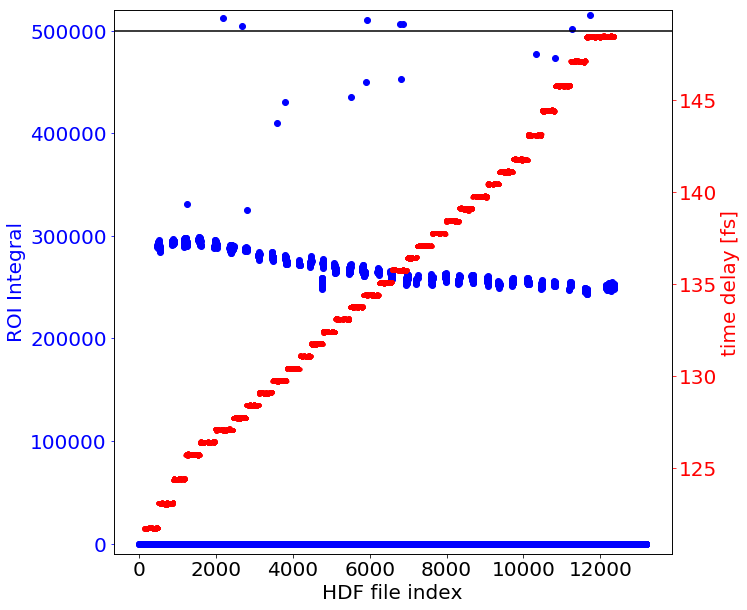

In [14]:
fig, ax1 = plt.subplots()
ax1.plot(integral,'bo')
ax1.set_xlabel('HDF file index')
ax1.set_ylabel('ROI Integral', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-10000,520000)

plt.axhline(y=500000, color='k')

ax2 = ax1.twinx()
ax2.plot(time_delay,'r.')
ax2.set_ylabel('time delay [fs]', color='r')
ax2.tick_params('y', colors='r')

plt.show()

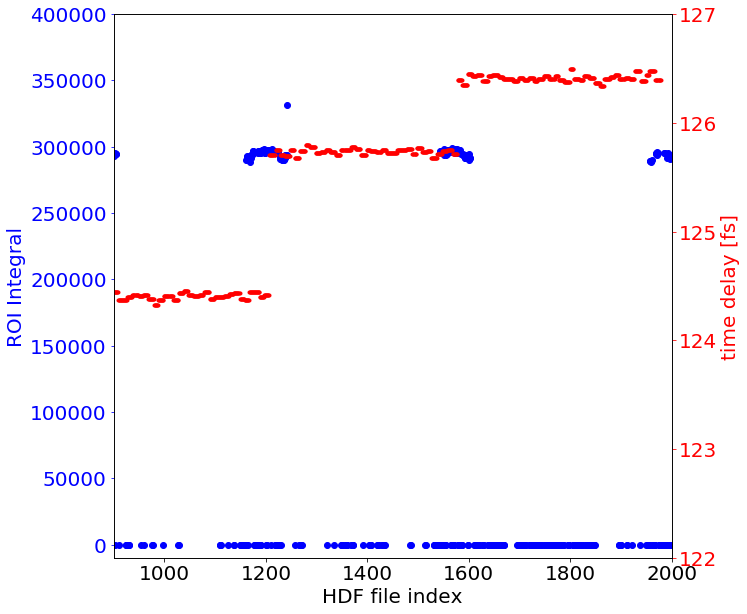

In [15]:
fig, ax1 = plt.subplots()
ax1.plot(integral,'bo')
ax1.set_xlabel('HDF file index')
ax1.set_ylabel('ROI Integral', color='b')
ax1.tick_params('y', colors='b')

ax1.set_ylim(-10000,400000)
ax1.set_xlim(900,2000)

ax2 = ax1.twinx()
ax2.plot(time_delay,'r.')
ax2.set_ylabel('time delay [fs]', color='r')
ax2.tick_params('y', colors='r')

ax2.set_ylim(122,127)

plt.show()

In [16]:
logic_map = (integral>1000)
res = [i for i, val in enumerate(logic_map) if val]
print('Number of blanks in the end:', len(logic_map)-res[-1])
print('Acutal Rate in dataset (without appended blanks): {0:.3f} '.format((len(res)/res[-1])))

Number of blanks in the end: 833
Acutal Rate in dataset (without appended blanks): 0.729 


# Example - Single Image
* selecting region of interest

In [17]:
img_number = 1300
zoom_height_top, zoom_height_down, zoom_width_left, zoom_width_right = 250, 700, 200, 650

example_img = img[img_number][zoom_height_top:zoom_height_down,zoom_width_left:zoom_width_right]

sec_height_top, sec_height_down  = 400, 500
sec_width_1_left, sec_width_1_right = 250, 300
sec_width_2_left, sec_width_2_right = 550, 600

img_section_1 = img[img_number][sec_height_top:sec_height_down, sec_width_1_left:sec_width_1_right]
img_section_2 = img[img_number][sec_height_top:sec_height_down, sec_width_2_left:sec_width_2_right]

In [18]:
def get_roi_plot_coor(x_left_top,y_left_top,x_right_down,y_right_down, cut_x, cut_y):
    x1 = x_left_top - cut_x
    y1 = y_left_top  - cut_y
    x2 = x_right_down - cut_x
    y2 = y_right_down - cut_y
    x_plot = [x1, x2, x2, x1, x1]
    y_plot = [y1, y1, y2, y2, y1]
    return x_plot, y_plot    

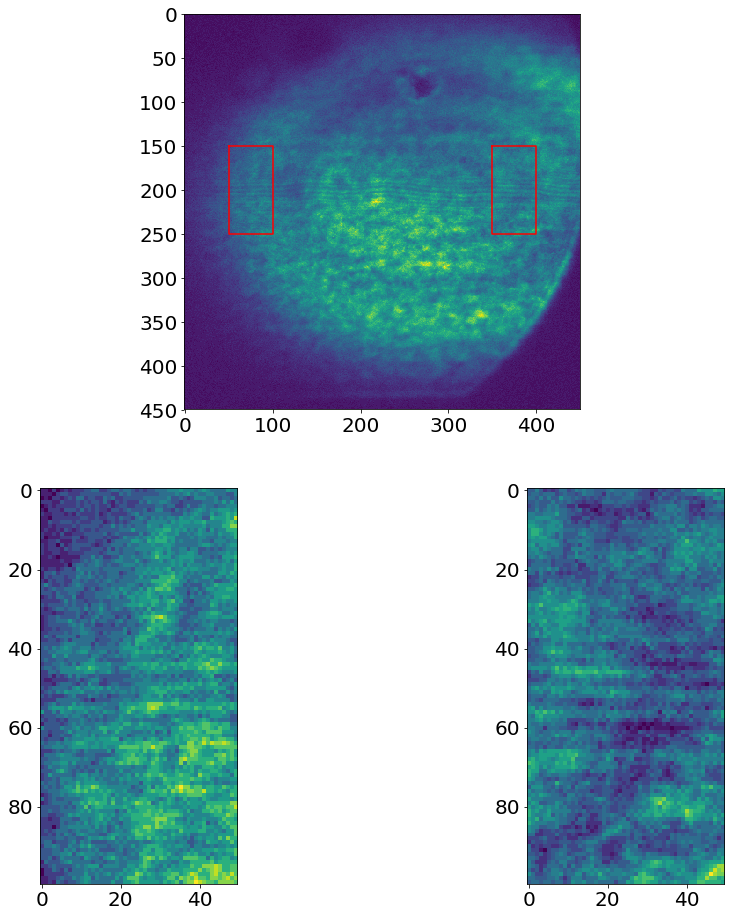

In [19]:
roi_1_x,roi_1_y = get_roi_plot_coor(sec_width_1_left,sec_height_top,sec_width_1_right,sec_height_down, zoom_width_left, zoom_height_top)
roi_2_x,roi_2_y = get_roi_plot_coor(sec_width_2_left,sec_height_top,sec_width_2_right,sec_height_down, zoom_width_left, zoom_height_top)

fig = plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.imshow(example_img)
ax.plot(roi_1_x, roi_1_y, 'r-')
ax.plot(roi_2_x, roi_2_y, 'r-')

ax1 = fig.add_subplot(gs[1, 0])
ax1.imshow(img_section_1)

ax2 = fig.add_subplot(gs[1, 1])
ax2.imshow(img_section_2)

plt.show()

### Utility functions for extracting visibility 
$$V = \frac{I_{max} - I_{min}}{I_{max}+I_{min}} $$

In [20]:
def extract_profile_line(integrate_image):
    start_sum = int(integrate_image.shape[1]/2)-20
    end_sum = int(integrate_image.shape[1]/2)+20
    return np.sum(integrate_image[:,start_sum:end_sum], axis=1)

def calc_visibility(profile_line):
    maxs = np.max(profile_line[40:60])     # cut to fringe pattern
    mins = np.min(profile_line[40:60])     # cut to fringe pattern
    return (maxs-mins)/(maxs+mins)

def extract_visibility_of_scan(first_image, last_image, sec_height_top, sec_height_down, sec_width_left, sec_width_right):
    profile_lines = np.asarray([extract_profile_line(img[index][sec_height_top:sec_height_down, sec_width_left:sec_width_right]) for index in range(first_image, last_image)])
    visibilities = np.asarray([calc_visibility(profile_lines[index]) for index in range(0,profile_lines.shape[0])])
    return visibilities

### Example profile lines

number of profile lines in 1st delay step: 498


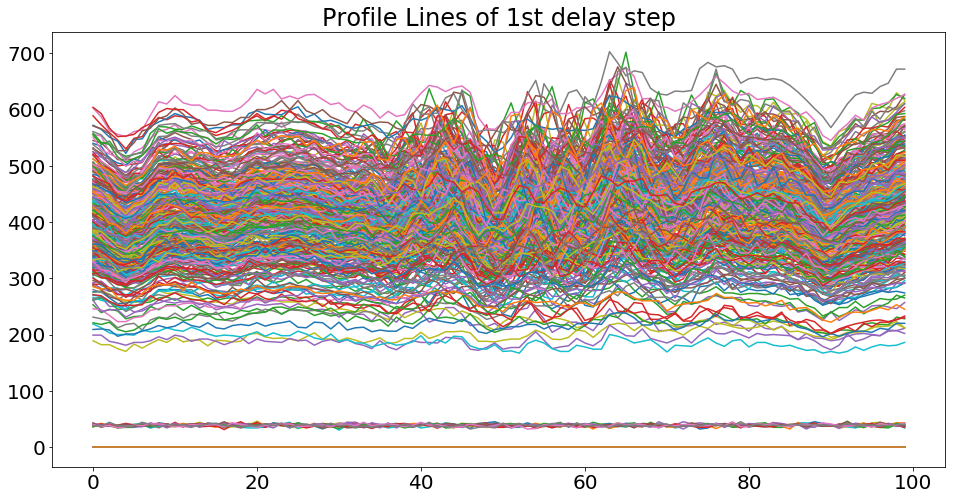

In [21]:
profile_lines_1_delay_step = np.asarray([extract_profile_line(img[index][sec_height_top:sec_height_down, sec_width_1_left:sec_width_1_right]) for index in range(index_delay_change[0])])

print('number of profile lines in 1st delay step:',len(profile_lines_1_delay_step))

plt.figure(figsize=(16,8))
[plt.plot(profile_lines_1_delay_step[index]) for index in range(profile_lines_1_delay_step.shape[0])]
plt.title('Profile Lines of 1st delay step');

### again 3 Types of profile lines: empty, dark & "lit" images

### Offset Plot

number of profile lines in 1st delay step: 20


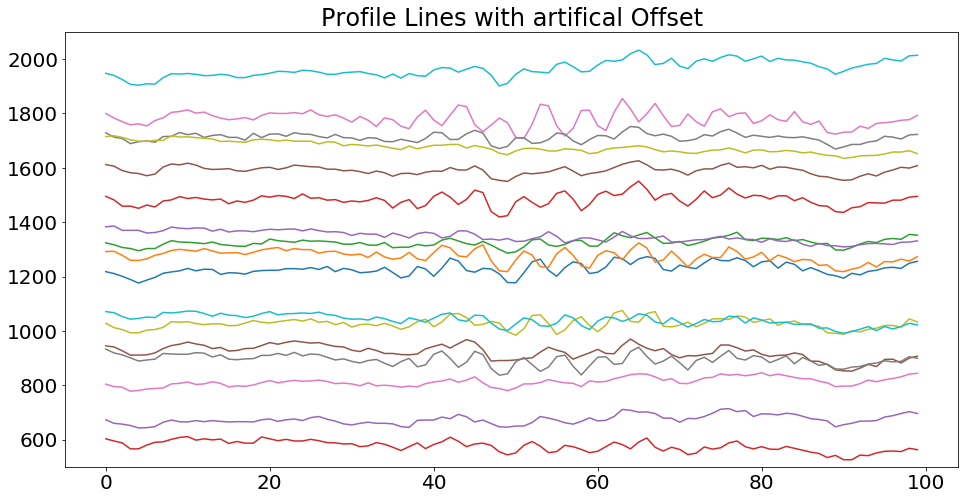

In [22]:
number_of_lines = 20

profile_lines_1_delay_step = np.asarray([extract_profile_line(img[index][sec_height_top:sec_height_down, sec_width_1_left:sec_width_1_right]) for index in range(number_of_lines)])

print('number of profile lines in 1st delay step:',len(profile_lines_1_delay_step))

plt.figure(figsize=(16,8))
[plt.plot(profile_lines_1_delay_step[index]+80 * index) for index in range(profile_lines_1_delay_step.shape[0])]
plt.title('Profile Lines with artifical Offset')
plt.ylim(500,2100)
plt.show()


### Image Vs Profile Line
* save to disk

In [23]:
def save_fig_single_shots(img,img_number, sec_height_top,sec_height_down, sec_width_1_left,sec_width_1_right, gmd_pulse_res_bda):
    profile_line = extract_profile_line(img[img_number][sec_height_top:sec_height_down, sec_width_1_left:sec_width_1_right])
    fig = plt.figure(figsize=(15,10))
    plt.subplot(211)
    plt.imshow(img[img_number][sec_height_top:sec_height_down, sec_width_1_left:sec_width_1_right])
    plt.subplot(212)
    plt.plot(profile_line)
    plt.title('V = {:.4f}'.format(calc_visibility(profile_line)))
    plt.savefig(image_path+'fringes_{}.png'.format(str(img_number)))    


In [24]:
img_number_start = 6400
img_number_end = 6500

# [save_fig_single_shots(img, index, sec_height_top,sec_height_down, sec_width_1_left,sec_width_1_right) for index in range(img_number_start,img_number_end)]

## Plot all Visibilities of Scan
* remove all images below treshold
* plot against time delay -> jitter include

In [25]:
visibilities = extract_visibility_of_scan(0, img.shape[0], sec_height_top,sec_height_down, sec_width_1_left,sec_width_1_right)

/software/anaconda3/5.2/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in ulong_scalars
  if __name__ == '__main__':


 ### eliminate images with closed shutter

In [26]:
lit_treshold = 500000
logic_map_lit = (integral > lit_treshold) 

### calculate averages per delay step

In [27]:
delay_steps = np.split(visibilities,index_delay_change)
logic_per_delay_step =  np.split(logic_map_lit, index_delay_change)

delay_steps_lit = [delay_steps[index][logic_per_delay_step[index]] for index in range(len(delay_steps))]

averages = [np.nanmean(delay_steps_lit[index]) for index in range(len(delay_steps_lit))]
std = [np.nanstd(delay_steps_lit[index]) for index in range(len(delay_steps_lit))]
time_delay_for_average = np.append(time_delay[index_delay_change], time_delay[-1000])

### Number of used pulses per delay step 

In [28]:
print([len(delay_steps_lit[index]) for index in range(len(delay_steps_lit))])

[335, 255, 221, 253, 210, 204, 213, 204, 220, 247, 219, 147, 189, 208, 263, 213, 271, 226, 260, 140, 286, 226, 246, 220, 240, 208, 234, 264, 178, 244, 272, 252, 380]


### Plot all values (blue) and average (red)

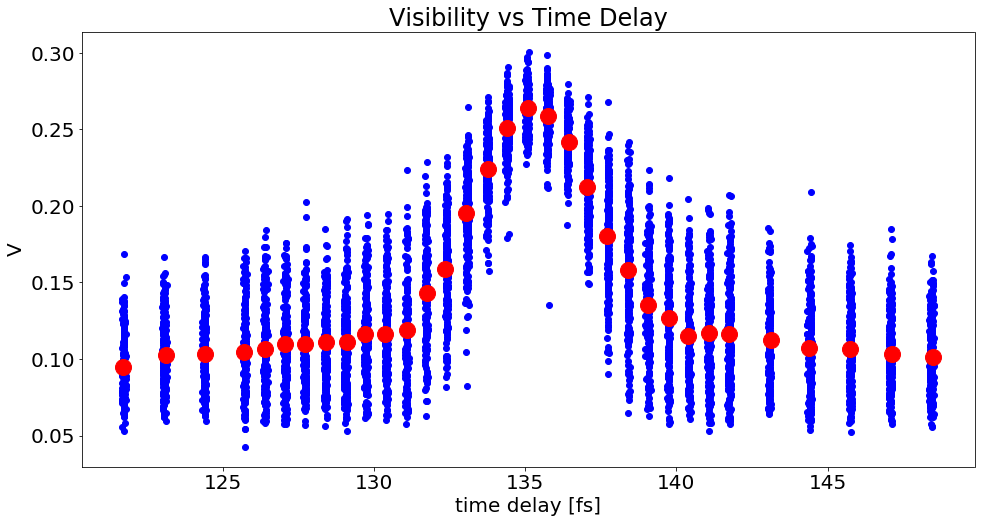

In [29]:
plt.figure(figsize=(16,8))
[plt.plot(time_delay[index],visibilities[index],'bo') for index in range(len(visibilities)) if logic_map_lit[index] == True]
plt.errorbar(time_delay_for_average,averages, yerr = std, fmt='o', color='r',  markersize=16)
plt.title('Visibility vs Time Delay')
plt.xlabel('time delay [fs]')
plt.ylabel('V');

### Plot average with standard error (1x sigma)
* average of all images of "lit treshold"
* 1 sigma show range of single meassurement 

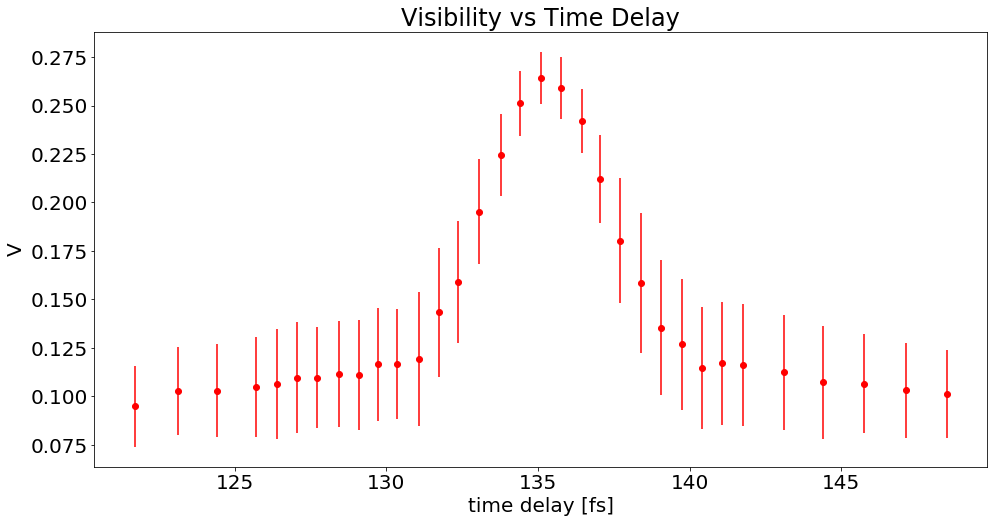

In [30]:
plt.figure(figsize=(16,8))
plt.errorbar(time_delay_for_average,averages, yerr = std, fmt='o', color='r')
plt.title('Visibility vs Time Delay')
plt.xlabel('time delay [fs]')
plt.ylabel('V');

## Normalize Fringe Visibility on BDA GMD

In [31]:
gmd_ave_bda_addr = '/FL1/Photon Diagnostic/GMD/Average energy/energy BDA (raw)'
gmd_pulse_res_bda_addr = '/FL1/Photon Diagnostic/GMD/Pulse resolved energy/energy BDA (raw)'

gmd_ave_bda = hdf_file[gmd_ave_bda_addr][()]
gmd_pulse_res_bda = hdf_file[gmd_pulse_res_bda_addr][()]

### Plot averaged and pulse resoleved BDA GMD

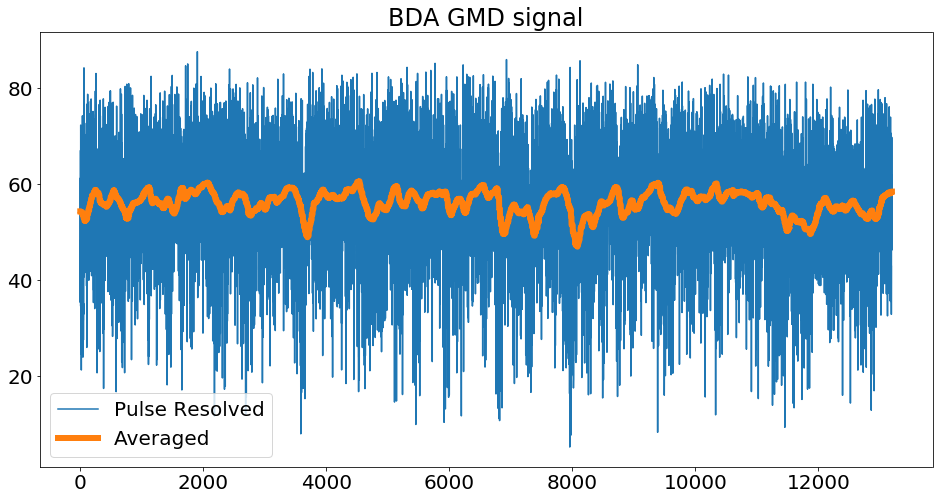

In [32]:
plt.figure(figsize=(16,8))
plt.plot(gmd_pulse_res_bda, label = 'Pulse Resolved')
plt.plot(gmd_ave_bda, linewidth = 6,label = 'Averaged')
plt.legend()
plt.title('BDA GMD signal');

* hardware-like filter on electron signal (pulse resolved) to correlate with ion signal (averaged)
* shift ion signal to compensate for time delay from Keyleigh

In [33]:
def filter_electron_signal(input_array):
    a0 = 0.00500145
    a1 = a0
    b1 = 1 - a0 - a1 
    output_list = [input_array[0]]
    for i in range(1,len(input_array)):
        output_list.append(a0 * input_array[i]+a1*input_array[i-1]+b1*output_list[i-1])
    return np.asarray(output_list)

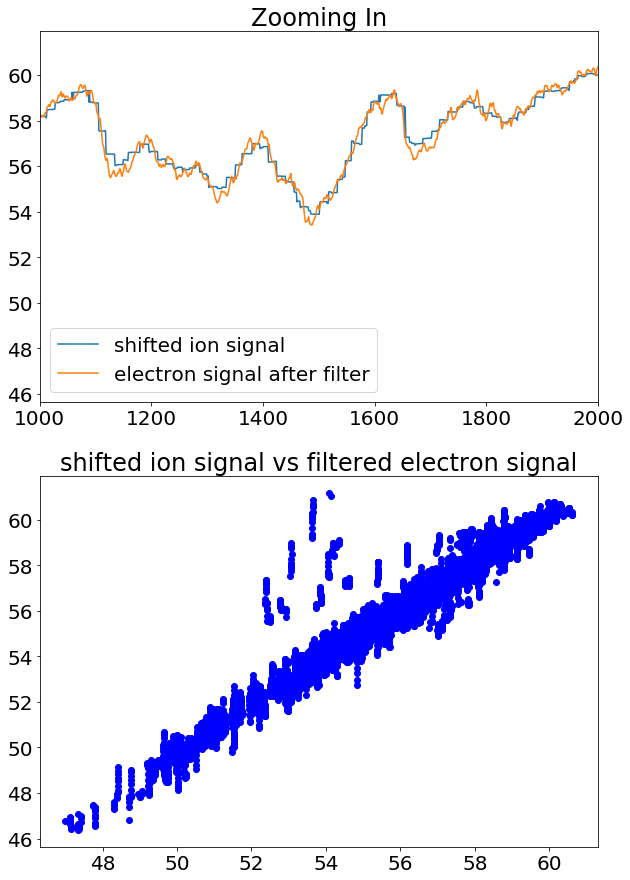

In [34]:
filtered_electron_gmd_bda = filter_electron_signal(np.nan_to_num(gmd_pulse_res_bda))
shift = -34
shifted_gmd_ave_bda =np.roll(gmd_ave_bda, shift)

plt.figure(figsize=(10,15))

plt.subplot(211)
plt.plot(shifted_gmd_ave_bda, label = 'shifted ion signal')
plt.plot(filtered_electron_gmd_bda,  label = 'electron signal after filter')
plt.legend()
plt.xlim(1000,2000)
plt.title('Zooming In')

plt.subplot(212)
plt.plot(shifted_gmd_ave_bda, filtered_electron_gmd_bda, 'bo')
plt.title('shifted ion signal vs filtered electron signal')
plt.show()

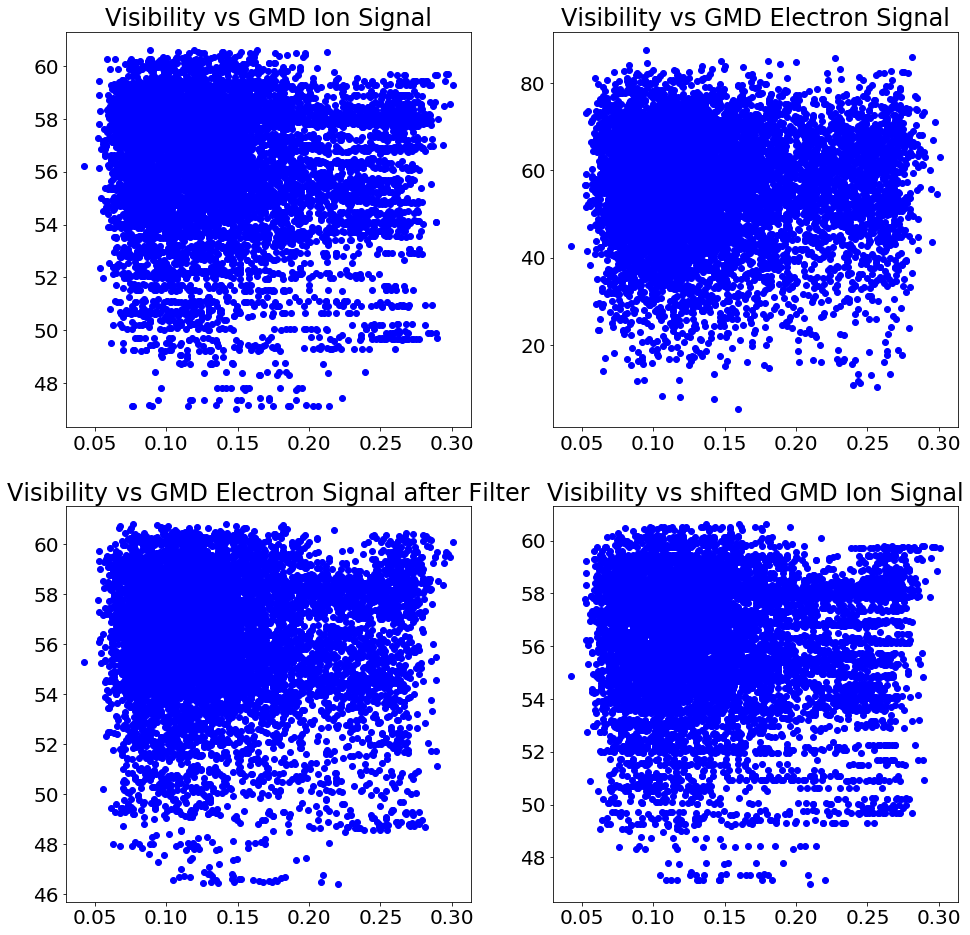

In [35]:
plt.figure(figsize=(16,16))

plt.subplot(221)
plt.plot(visibilities, gmd_ave_bda, 'bo')
plt.title('Visibility vs GMD Ion Signal')

plt.subplot(222)
plt.plot(visibilities, gmd_pulse_res_bda, 'bo')
plt.title('Visibility vs GMD Electron Signal')

plt.subplot(223)
plt.plot(visibilities, filtered_electron_gmd_bda, 'bo')
plt.title('Visibility vs GMD Electron Signal after Filter')

plt.subplot(224)
plt.plot(visibilities, shifted_gmd_ave_bda, 'bo')
plt.title('Visibility vs shifted GMD Ion Signal')
plt.show()

## Densitiy Plots
to much points to extract information

In [36]:
def calc_density_of_correlation(array1, array2, nbins = 300):    
    x = np.asarray([array1[index] for index in range(len(array1)) if array1[index] == array1[index] and array2[index] == array2[index]])
    y = np.asarray([array2[index] for index in range(len(array2)) if array1[index] == array1[index] and array2[index] == array2[index]])
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return xi, yi, zi.reshape(xi.shape) 

def plot_pensity_of_correlation(array1, array2, nbins = 300):
    x, y, z = calc_density_of_correlation(array1, array2, nbins = 300)
    plt.pcolormesh(x,y,z)

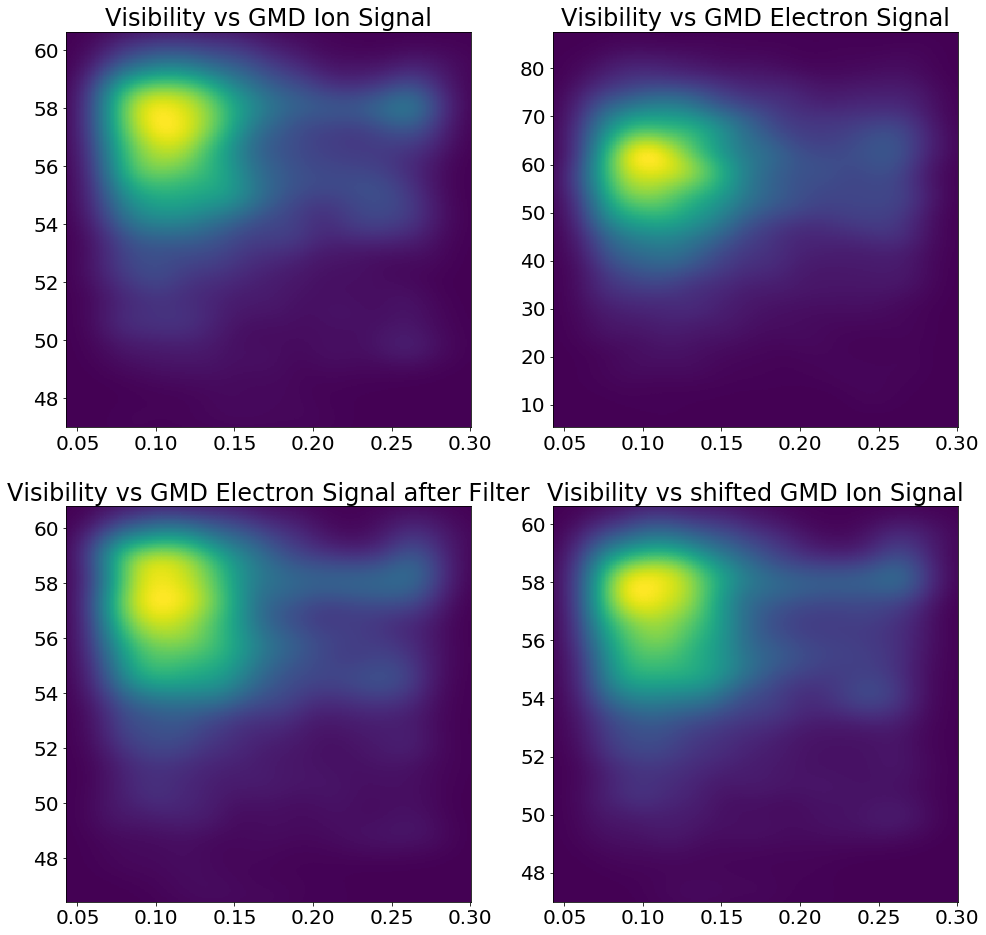

In [37]:
plt.figure(figsize=(16,16))

plt.subplot(221)
plot_pensity_of_correlation(visibilities, gmd_ave_bda.flatten())
plt.title('Visibility vs GMD Ion Signal')

plt.subplot(222)
plot_pensity_of_correlation(visibilities, gmd_pulse_res_bda.flatten())
plt.title('Visibility vs GMD Electron Signal')

plt.subplot(223)
plot_pensity_of_correlation(visibilities, filtered_electron_gmd_bda.flatten())
plt.title('Visibility vs GMD Electron Signal after Filter')

plt.subplot(224)
plot_pensity_of_correlation(visibilities, shifted_gmd_ave_bda.flatten())
plt.title('Visibility vs shifted GMD Ion Signal')
plt.show()


# No Normalization possible ?
* temporal coherence length is not understandably correlated with pulse energy 
* influence on Visibility is not linear  

## Find Time Zero and FWHM

### Utility functions

In [38]:
def gaus(x,a,x0,sigma,offset):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+offset

def fit_params_gaus(x, y):
    n = np.sum(y)
    mean = np.sum(y * x) / n
    sigma= np.sqrt(np.sum(y * (x - mean) ** 2) / n)
    popt,pcov = curve_fit(gaus, x, y, p0=[1, mean, sigma, 0.0])
    return popt

def find_fwhm(x,y, offset):
    half_max = (np.max(y)+offset)/2
    d = y - half_max
    indexes = np.where(d > 0)[0]
    return x[indexes[0]], x[indexes[-1]]


In [39]:
def delay_scan_from_image_section(img, sec_height_top, sec_height_down, sec_width_left, sec_width_right, index_delay_change, logic_map_lit):
    visibilities = extract_visibility_of_scan(0, img.shape[0], sec_height_top,sec_height_down, sec_width_left,sec_width_right)
    delay_steps = np.split(visibilities,index_delay_change)
    logic_per_delay_step =  np.split(logic_map_lit, index_delay_change)
    delay_steps_lit = [delay_steps[index][logic_per_delay_step[index]] for index in range(len(delay_steps))]  
    averages = [np.nanmean(delay_steps_lit[index]) for index in range(len(delay_steps_lit))]
    std = np.asarray([np.nanstd(delay_steps_lit[index]) for index in range(len(delay_steps_lit))])
    shots_in_delay_steps = np.asarray([count_non_nans(delay_steps_lit[index]) for index in range(len(delay_steps_lit))])
    err = std/np.sqrt(shots_in_delay_steps)
    time_delay_for_average = np.append(time_delay[index_delay_change], time_delay[-1000])
    return time_delay_for_average, averages, err

def fit_scan_to_gaus(time_delay_for_average, averages):
    popt = fit_params_gaus(time_delay_for_average , averages)
    time_for_gaus = np.linspace(time_delay_for_average[0],time_delay_for_average[-1],1000)
    gaus_fit = gaus(time_for_gaus,*popt)
    return time_for_gaus, gaus_fit, popt[1], popt[3]
    

def make_fwhm_plot(img, sec_height_top, sec_height_down, sec_width_left, sec_width_right, index_delay_change, logic_map_lit):
    
    time_delay_for_average, averages, err = delay_scan_from_image_section(img, sec_height_top, sec_height_down, sec_width_left, sec_width_right, index_delay_change, logic_map_lit)
    gaus_x, gaus_y, time_zero, offset = fit_scan_to_gaus(time_delay_for_average , averages)
    fwhm_range = find_fwhm(gaus_x, gaus_y, offset)

    fig = plt.figure(figsize=(16,8))
    plt.errorbar(time_delay_for_average,averages, yerr = err, fmt='o', color='r')
    plt.plot(gaus_x,gaus_y,'c.',label='fit')
    plt.axvspan(fwhm_range[0], fwhm_range[1], facecolor='g', alpha=0.1, label='FWHM')
    plt.title('Visibility vs Time Delay')
    plt.text(time_zero+5,offset*1.2,'$t_0$ = {:.2f} fs'.format(time_zero))
    plt.text(134,offset,'{:.2f} fs'.format(fwhm_range[1]-fwhm_range[0]))
    plt.legend()
    plt.xlabel('time delay [fs]')
    plt.ylabel('V')
    

/software/anaconda3/5.2/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in ulong_scalars
  if __name__ == '__main__':


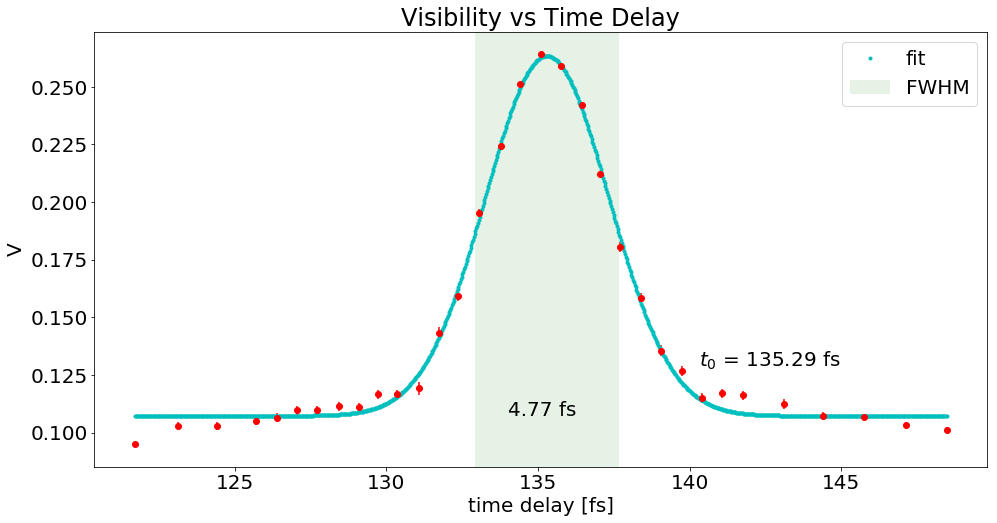

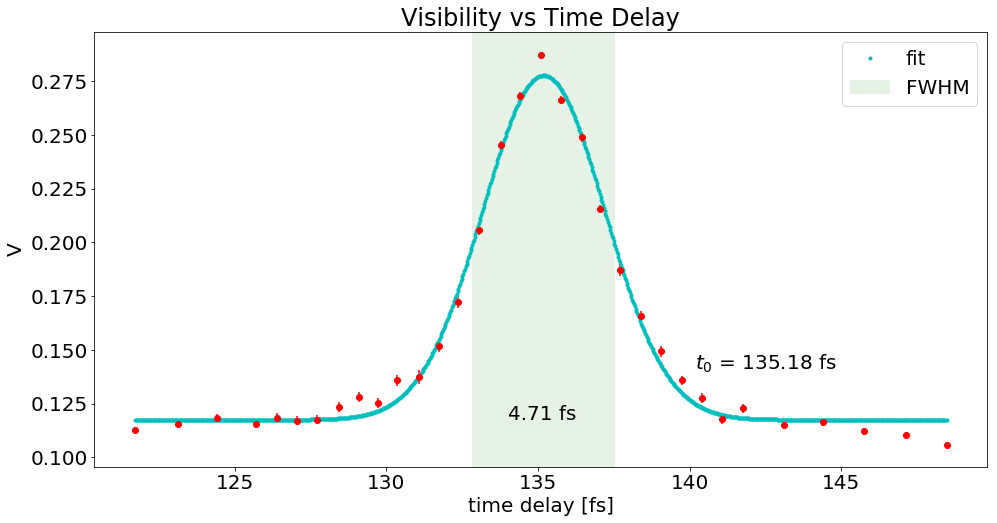

In [40]:
make_fwhm_plot(img, sec_height_top, sec_height_down, sec_width_1_left, sec_width_1_right, index_delay_change, logic_map_lit)
make_fwhm_plot(img, sec_height_top, sec_height_down, sec_width_2_left, sec_width_2_right, index_delay_change, logic_map_lit)